In [122]:
import pandas as pd
from pandas_datareader import DataReader
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cvx

import matplotlib.dates as mdates
import seaborn as sns

import pandas_datareader.data as web   

In [123]:
ret_det_for_all = 0.04
risk_det_for_all = 0.09
market = 'usa' # cab be rus or usa (str)

if market == 'usa':
    index_name = '^GSPC' # ticker of SP500
else:
    index_name = 'IMOEX'

# Data loading

In [127]:
df_all = pd.read_csv(f'data/data_all_{market}.csv', index_col=0)
df_all.index = pd.to_datetime(df_all.index)

In [128]:
if index_name in df_all.columns:
    assets = df_all.drop([index_name], axis=1).columns
else:
    assets = df_all.columns

In [129]:
df_all_pct = df_all.pct_change().iloc[1:]
df_all_pct

,AAPL,AMZN,BABA,DIS,EBAY,F,FB,GOOGL,INTC,KO,MCD,MSFT,NFLX,NKE,SBUX,T,TSLA,^GSPC
TRADEDATE,,,,,,,,,,,,,,,,,,
2015-01-05,-0.028172,-0.020517,-0.025097,-0.014613,-0.008361,-0.039062,-0.016061,-0.019054,-0.011276,0.000000,-0.011044,-0.009196,-0.050897,-0.016100,-0.019155,-0.009448,-0.042041,-0.018278
2015-01-06,0.000094,-0.022833,0.022970,-0.005304,-0.012917,-0.009485,-0.013473,-0.024679,-0.018637,0.007594,0.001843,-0.014677,-0.017121,-0.005882,-0.008137,0.001490,0.005664,-0.008893
2015-01-07,0.014022,0.010600,-0.011518,0.010230,-0.001636,0.028728,0.000000,-0.002941,0.020975,0.012482,0.017424,0.012705,0.005192,0.020656,0.024612,-0.012798,-0.001562,0.011630
2015-01-08,0.038422,0.006836,0.028395,0.010341,0.026943,0.025266,0.026658,0.003484,0.018601,0.012096,0.003723,0.029418,0.022188,0.023084,0.016137,0.009949,-0.001564,0.017888
2015-01-09,0.001073,-0.011749,-0.019137,0.004905,-0.013827,-0.013619,-0.005628,-0.012211,0.001908,-0.011032,-0.012187,-0.008405,-0.015458,-0.011024,-0.032731,-0.002985,-0.018802,-0.008404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-28,0.024992,0.015941,0.003309,0.000767,-0.067602,0.087041,0.015054,-0.002520,0.003967,0.009366,0.011412,0.003651,0.016789,0.012997,-0.002731,0.019553,0.037751,0.009829
2021-10-29,-0.018156,-0.021511,-0.028565,-0.003595,0.059522,0.013049,0.020983,0.015064,0.019135,0.005889,0.000204,0.022414,0.024123,0.017208,-0.062986,-0.011350,0.034316,0.001949
2021-11-01,-0.005607,-0.016107,0.031708,0.006624,-0.005474,0.050937,0.019810,-0.030727,0.011224,-0.003548,0.020485,-0.006785,-0.013240,-0.005738,0.035165,0.004355,0.084910,0.001800


# Classes protfolio

In [130]:
def markov_random_search(ret_det, returns, cov_mat, step = 0.015):

    weights = np.array([1/len(returns)]*len(returns))
    risk_min = 1  #return_max : макс доходность

    for i in range(10**4): #uniform or normal
        
        rand_vec = np.random.uniform(low = - step, high = 0.015, size = returns.shape) 
        rand_vec_centr =  rand_vec - np.mean(rand_vec) #normalization

        weights_loc = weights + rand_vec_centr 

        ret_loc, risk_loc = port_return_risk(weights_loc, cov_mat.values, returns.values)

        if ret_loc > ret_det and risk_loc < risk_min and weights_loc.min()>0.001 and weights_loc.max()< 0.5:
            weights = weights_loc
            ret_min = ret_loc
            
    return weights

In [131]:
def markov_convex_optim(ret_det, returns, cov_mat):
    
    n = len(mu)
    x = cvx.Variable(n, nonneg=True)
    ones_vec = np.ones(n)

    obj = cvx.Minimize(cvx.matrix_frac(x, Sigma))
    constraints = [mu.T @ x >= ret_det,
                    np.ones(n).T @ x == 1]

    prob = cvx.Problem(obj, constraints)
    prob.solve()

    weights = x.value

    return weights

In [132]:
class MarkovPortfolio:
    def __init__(self, returns, cov_mat, args):
        self.returns = returns
        self.cov_mat = cov_mat
        self.ret_det = args['ret_det']
        
    def fit(self):
        n = len(self.returns)
        x = cvx.Variable(n, nonneg=True)

        obj = cvx.Minimize(cvx.matrix_frac(x, self.cov_mat))
        constraints = [self.returns.T @ x >= self.ret_det,
                        np.ones(n).T @ x == 1]

        prob = cvx.Problem(obj, constraints)
        prob.solve()

        weights = x.value
        return weights

In [133]:
class TobinPortfolio:
    def __init__(self, returns, cov_mat, args):
        self.returns = returns
        self.cov_mat = cov_mat
        self.risk_det = args['risk_det']
        
    def fit(self):
        n = len(self.returns)
        x = cvx.Variable(n, nonneg=True)

        obj = cvx.Maximize(self.returns.T @ x)
        constraints = [cvx.matrix_frac(x, self.cov_mat) <= np.sqrt(self.risk_det),
                        np.ones(n).T @ x == 1]

        prob = cvx.Problem(obj, constraints)
        prob.solve()

        weights = x.value
        return weights

In [134]:
class SharpPortfolio:
    def __init__(self, returns, cov_mat, args):
        self.returns = returns
        self.cov_mat = cov_mat
        self.ret_det = args['ret_det']
        
    def fit(self):
        n = len(self.returns)
        x = cvx.Variable(n, nonneg=True)
        ones_vec = np.ones(n)

        obj = cvx.Maximize((self.returns.T @ x - self.ret_det)/ cvx.matrix_frac(x, self.cov_mat)**0.5)
        constraints = [np.ones(n).T @ x == 1]

        prob = cvx.Problem(obj, constraints)
        prob.solve()

        weights = x.value
        return weights

In [ ]:
class TreynorPortfolio:
    def __init__(self, returns, covar_vec, sigma_m, ret_det):
        self.returns = returns
        self.covar_vec = covar_vec
        self.sigma_m = sigma_m
        self.ret_det = ret_det
        
        
    def fit(self):
        n = len(self.returns)
        x = cvx.Variable(n, nonneg=True)

        obj = cvx.Maximize((self.returns.T @ x - self.ret_det) * self.sigma_m/(self.covar_vec.T @ x))
        constraints = [np.ones(n).T @ x == 1,
                      np.eye(n) @ x <= 0.3]

        prob = cvx.Problem(obj, constraints)
        prob.solve(qcp=True)

        weights = x.value
        return weights

In [ ]:
class JensenPortfolio:
    def __init__(self, returns, covar_vec, sigma_m, ret_det):
        self.returns = returns
        self.covar_vec = covar_vec
        self.sigma_m = sigma_m
        self.ret_det = ret_det
        
        
    def fit(self):
        n = len(self.returns)
        x = cvx.Variable(n, nonneg=True)

        obj = cvx.Maximize(self.returns.T @ x - (self.ret_det + (self.returns.T - self.ret_det) * self.covar_vec.T @ x / self.sigma_m))
        constraints = [np.ones(n).T @ x == 1,
                      np.eye(n) @ x <= 0.3]

        prob = cvx.Problem(obj, constraints)
        prob.solve()

        weights = x.value
        return weights

# Analitical functions

In [135]:
def mean_year_return(df):
    year_return = df.reset_index().groupby(pd.Grouper(key="TRADEDATE", freq="Y")).sum() + 1
    return year_return.prod() ** (1/len(year_return)) -1

def mean_year_vol(df):
    return df.reset_index().groupby(pd.Grouper(key="TRADEDATE", freq="Y")).std().apply(lambda x: x*252**0.5).mean()

In [136]:
def find_max_drawdown(prices):
    """
    Takes Series with closing prices.
    Returns the value of maximum drawdown
    in percent and indexes of prices where this
    maximum drawdown took place. If stock is
    always growing it will return minimum
    growth with and indexes of prices where this
    minimum growth took place.
    """
    max_price = prices.iloc[0]
    curr_drawdown = 0
    max_drawdown = 0
    curr_left = 0
    left = 0
    right = 0
    for i in range(0, len(prices)):
        curr_drawdown = (prices.iloc[i] / max_price - 1) * 100
        if curr_drawdown < max_drawdown:
            max_drawdown = curr_drawdown
            left = curr_left
            right = i
        if prices.iloc[i] > max_price:
            max_price = prices.iloc[i]
            curr_left = i
    return max_drawdown, left, right

def calc_growth(prices):
    """
    Calculates list with growth
    """
    growth = []
    past_p = 0
    for p in prices:
        if past_p:
            growth.append(p - past_p)
        past_p = p
    return growth

def find_max_recovery(prices):
    """
    Takes Series with closing prices.
    Returns the value of maximum recovery
    period in days and indexes of prices
    where this recovery period took place.
    """
    growth = calc_growth(prices)
    s = 0
    left = 0
    right = 0
    curr_left = 0
    max_recovery = 0
    for i in range(0, len(growth)):
        if not s:
            curr_left = i
        s += growth[i]
        if s > 0:
            s = 0
            if max_recovery < (i - curr_left):
                max_recovery = i - curr_left
                left = curr_left
                right = i
            
    return max_recovery, left, right + 1

In [137]:
def plot_weights_pie(weights_year, label=''):
    ress = []

    for j, weight in enumerate(weights_year):
        as_wei = dict()

        for i in range(len(assets)):
            as_wei[assets[i]] = weight[i]

        res = pd.DataFrame(as_wei.values(), index = as_wei.keys(), columns = ['Asset']).query('Asset > 0.02')
        res = res.sort_values(by = 'Asset')
        if  round(1 - res.Asset.sum(), 5) != 0:
            res.loc['others'] = round(1 - res.Asset.sum(), 5)

        ress.append(res)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,9))
    
    fig.suptitle(f'** {label} **', fontsize=18)
    for i, ax in enumerate(axes.flat):
        labels = ress[i].index
        sizes =  ress[i].values

        colors = [plt.cm.Spectral(i/float(len(sizes.flatten())-1)) for i in range(len(sizes))]
        ax.pie(sizes.flatten(), labels=labels,
            autopct='%1.1f%%', shadow=True, startangle=140, colors = colors)

        ax.set_title(str(int(2018+i)), {'fontsize': 19})
        

    plt.show()

In [139]:
def calculate_measures(return_portfolio):

    """
    return a list with:
    - mean year return
    - mean year volatility
    - max drawdown for whole period
    - max period of recovery for whole period
    """

    mean_year_ret = mean_year_return(return_portfolio['portfolio'])
    mean_year_risk = mean_year_vol(return_portfolio['portfolio'])

    max_drawdown = find_max_drawdown(return_portfolio['cumprod'])
    max_recovery = find_max_recovery(return_portfolio['cumprod'])

    port_measures = list(map(float, [mean_year_ret, mean_year_risk, max_drawdown[0], max_recovery[0]]))

    return port_measures

In [140]:
def show_stats_of_stock(data, label=''):

    """
    draw a plot with
    - max drawdown for whole period
    - max period of recovery for whole period
    """
 
    # find max drowdawn boundaries in appropriate format
    max_drawdown = find_max_drawdown(data)
    max_drawdown_date = [pd.to_datetime(data.axes[0].tolist()[max_drawdown[1]]), pd.to_datetime(data.axes[0].tolist()[max_drawdown[2]])]
    max_drawdown_val = [data.iloc[max_drawdown[1]], data.iloc[max_drawdown[2]]]
 
    # find max recovery period boundaries in appropriate format
    max_recovery = find_max_recovery(data)
    max_recovery_date = [pd.to_datetime(data.axes[0].tolist()[max_recovery[1]]), pd.to_datetime(data.axes[0].tolist()[max_recovery[2]])]
    max_recovery_val = [data.iloc[max_recovery[1]], data.iloc[max_recovery[2]]]
 
    # plot data
    fig, ax = plt.subplots(1, figsize=(8,4.3))
    plt.plot(data,  color = 'blue')
 
    # plot max drawdowd
    max_drawdown_section = np.arange(max_drawdown[1], max_drawdown[2], 1)
    date_max_drawdown_section = pd.to_datetime(np.array(data.axes[0].tolist())[max_drawdown_section])
    #plt.fill_between(date_max_drawdown_section, data[date_max_drawdown_section], color = 'red', label = "макс. просадка")
    #print(data.iloc[max_drawdown[1]])
    plt.hlines(data.iloc[max_drawdown[1]], data.index[0], data.index[max_drawdown[1]], label = "max drawdown", colors='#808080', linestyles= '--', linewidth = 2)
    plt.hlines(data.iloc[max_drawdown[2]], data.index[0], data.index[max_drawdown[2]],  colors='#808080', linestyles= '--', linewidth = 2)

    plt.ylabel("max drawdown {}%".format(round(-max_drawdown[0], 1)), fontweight='bold', fontsize=11)
 
    # plot max recovery period
    max_recovery_section = np.arange(max_recovery[1], max_recovery[2], 1)
    date_max_recovery_section = pd.to_datetime(np.array(data.axes[0].tolist())[max_recovery_section])
    max_price = max(data)
    #plt.fill_between(date_max_recovery_section, data[date_max_recovery_section], max_price + 1, color = 'magenta', label = "макс. период восстановления")
    plt.fill_between(date_max_recovery_section, data[date_max_recovery_section], color = '#ffc0cb', label = "max recovery per.")

    plt.xlabel("max recovery per {} days".format(round(max_recovery[0], 0)), fontweight='bold', fontsize=11)

    xfmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_formatter(xfmt)

    plt.ylim([min(data)-0.1, np.max(data.values) + 0.1])

    fig.patch.set_visible(False)
    #ax.axis('off')

    plt.grid(color='#cccccc', linewidth = 0.5)
    plt.title(label)
    plt.legend()
    plt.show()

In [142]:
# variable with results
indics = pd.DataFrame(df_all[index_name].values, index=df_all[index_name].index, columns=['data'])
indics = indics[(indics.index > datetime(2018, 1, 1)) & (indics.index < datetime(2018 + 4, 1, 1))]
indics['cumprod'] = (indics.pct_change() + 1).cumprod()
indics['portfolio'] = indics['cumprod'] / indics['cumprod'].shift() - 1
indics = indics.iloc[2:]

In [143]:
d = dict()
d['indics'] = indics['cumprod']

In [144]:
all_weights_all_years =  pd.DataFrame([])

In [145]:
df_res = pd.DataFrame(calculate_measures(indics), index = ['mean_return', 'mean_risk', 'max_drawndown', 'max_recovery'], columns = [index_name])
df_res

,^GSPC
mean_return,0.149573
mean_risk,0.191497
max_drawndown,-33.924960
max_recovery,145.000000


In [146]:
# равновесный портфель
return_portfolio_equal = pd.DataFrame([])

index_in_bool = index_name in df_all.columns
for i in range(4): #цикл, при помощи которого ты скользящее среднее
    

    weights = np.ones(len(assets))/len(assets)
   
    returns_test = df_all_pct[(df_all_pct.index > datetime(2018 + i, 1, 1)) & (df_all_pct.index < datetime(2019 + i, 1, 1))]\
    
    if index_in_bool:
        returns_test = returns_test.drop([index_name], axis=1)

    # расчет динамики портфеля за данный период
    return_portfolio_loc = pd.DataFrame(returns_test.values.dot(weights), index = returns_test.index, columns = ['portfolio'])

    # запись результатов динамики в результирующую переменную
    return_portfolio_equal = pd.concat([return_portfolio_equal, return_portfolio_loc])
    
return_portfolio_equal['temp']  = return_portfolio_equal['portfolio'] + 1
return_portfolio_equal['cumprod'] = return_portfolio_equal['temp'].cumprod()

df_res['Equal'] = calculate_measures(return_portfolio_equal)
d['Equal'] = return_portfolio_equal['cumprod']

In [147]:
df_res

,^GSPC,Equal
mean_return,0.149573,0.242020
mean_risk,0.191497,0.209625
max_drawndown,-33.924960,-31.929792
max_recovery,145.000000,185.000000


# Backtesting

In [148]:
def backtesting_universal(data, port_model = MarkovPortfolio, **args):
    weights_year = []
    return_portfolio = pd.DataFrame([])

    for i in range(4): #цикл, при помощи которого ты скользящее среднее

        # фильтрация данных
        returns_train = data[(data.index > datetime(2015 + i, 1, 1)) & (data.index < datetime(2018 + i, 1, 1))]

        # расчет портфеля
        #print(args)
        #ret_det = args[0]
            
        mu = (((returns_train+1).prod())**(1/len(returns_train))- 1).values * 252 # средняя доходность за год (252 раб дня)
        Sigma = returns_train.cov().values*252 # ковариационная матрица за год (252 раб дня) 
        
        

        port_ = port_model(mu, Sigma, args)
        weights = port_.fit()

        weights_year.append(weights)

       
        returns_test = data[(data.index > datetime(2018 + i, 1, 1)) & (data.index < datetime(2019 + i, 1, 1))]
        
            
        # расчет динамики портфеля за данный период
        return_portfolio_loc = pd.DataFrame(returns_test.values @ weights, index = returns_test.index, columns = ['portfolio'])

        # запись результатов динамики в результирующую переменную
        return_portfolio = pd.concat([return_portfolio, return_portfolio_loc])
        
    return weights_year, return_portfolio

In [149]:
df_all_pct.columns

Index(['AAPL', 'AMZN', 'BABA', 'DIS', 'EBAY', 'F', 'FB', 'GOOGL', 'INTC', 'KO',
       'MCD', 'MSFT', 'NFLX', 'NKE', 'SBUX', 'T', 'TSLA', '^GSPC'],
      dtype='object')

## Markov

In [150]:
label = 'Markov'

weights_year, return_portfolio = backtesting_universal(df_all_pct.drop([index_name], axis=1), ret_det=ret_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

,^GSPC,Equal,Markov
mean_return,0.149573,0.242020,0.293811
mean_risk,0.191497,0.209625,0.230052
max_drawndown,-33.924960,-31.929792,-30.274186
max_recovery,145.000000,185.000000,187.000000


In [ ]:
def backtesting_universal(data, port_model = MarkovPortfolio, **args):
    weights_year = []
    return_portfolio = pd.DataFrame([])

    for i in range(4): #цикл, при помощи которого ты скользящее среднее

        # фильтрация данных
        returns_train = data[(data.index > datetime(2015 + i, 1, 1)) & (data.index < datetime(2018 + i, 1, 1))]

        # расчет портфеля
        #print(args)
        #ret_det = args[0]
            
        mu = (((returns_train+1).prod())**(1/len(returns_train))- 1).values * 252 # средняя доходность за год (252 раб дня)
        Sigma = returns_train.cov().values*252 # ковариационная матрица за год (252 раб дня) 
        

        port_ = port_model(mu, Sigma, args)
        weights = port_.fit()

        weights_year.append(weights)

       
        returns_test = data[(data.index > datetime(2018 + i, 1, 1)) & (data.index < datetime(2019 + i, 1, 1))]
        
            
        # расчет динамики портфеля за данный период
        return_portfolio_loc = pd.DataFrame(returns_test.values @ weights, index = returns_test.index, columns = ['portfolio'])

        # запись результатов динамики в результирующую переменную
        return_portfolio = pd.concat([return_portfolio, return_portfolio_loc])
        
    return weights_year, return_portfolio

In [151]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])
all_weights_all_years

,2018,2019,2020,2021,portfolio
AAPL,0.059959,0.061260,0.068676,0.068736,Markov
AMZN,0.078318,0.083613,0.080974,0.058757,Markov
BABA,0.071230,0.077561,0.081969,0.056646,Markov
DIS,0.040712,0.039346,0.039162,0.055461,Markov
EBAY,0.059678,0.054671,0.053156,0.043504,Markov
F,0.050877,0.046802,0.045165,0.058900,Markov
FB,0.069599,0.073644,0.074273,0.066832,Markov
GOOGL,0.064820,0.066909,0.069031,0.061935,Markov
INTC,0.054191,0.065172,0.067499,0.068998,Markov
KO,0.026440,0.020194,0.017677,0.034840,Markov


<ipython-input-137-5d2732b82d49>:25: MatplotlibDeprecationWarning:

normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 



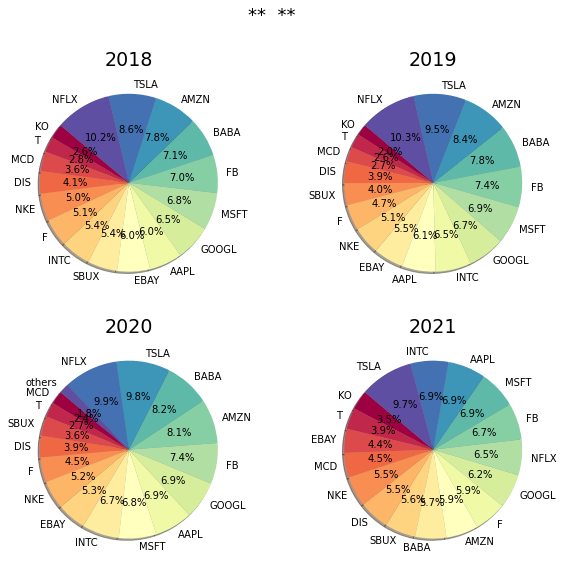

In [152]:
weights_year = all_weights_all_years[all_weights_all_years.portfolio == label]
plot_weights_pie(weights_year.iloc[:, :-1].T.values)

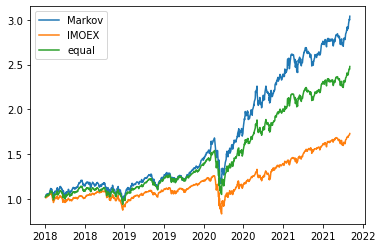

In [153]:
fig, ax = plt.subplots(1)

plt.plot(d['Markov'],label='Markov')
plt.plot(d['indics'],label='IMOEX')
plt.plot(d['Equal'],label='equal')

xfmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(xfmt)

plt.legend()

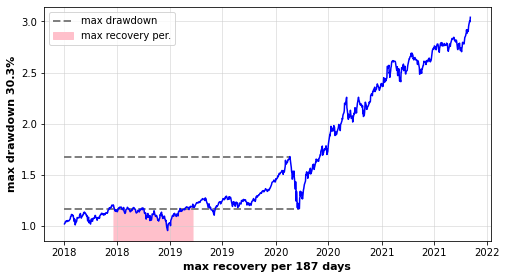

In [154]:
show_stats_of_stock(d['Markov'])

## Tobin

In [155]:
label = 'Tobin'

weights_year, return_portfolio = backtesting_universal(df_all_pct.drop([index_name], axis=1), port_model = TobinPortfolio, risk_det=risk_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

,^GSPC,Equal,Markov,Tobin
mean_return,0.149573,0.242020,0.293811,0.364250
mean_risk,0.191497,0.209625,0.230052,0.271099
max_drawndown,-33.924960,-31.929792,-30.274186,-29.480177
max_recovery,145.000000,185.000000,187.000000,187.000000


In [156]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])

## Treynor

In [158]:
def backtesting_treynor_jensen(data, index_ticker='', port_model = MarkovPortfolio, return_det=0.03):
    weights_year = []
    return_portfolio = pd.DataFrame([])

    for i in range(4): #цикл, при помощи которого ты скользящее среднее

        # фильтрация данных
        returns_train = data[(data.index > datetime(2015 + i, 1, 1)) & (data.index < datetime(2018 + i, 1, 1))]

        # расчет портфеля
        #print(args)
        #ret_det = args[0]
        
        if index_ticker != '':
            market_cov = returns_train.cov()[index_ticker] *252
            market_sigma = market_cov[index_ticker]#.values #[0]
            market_cov = market_cov.drop(index_ticker, axis=0).values
            
            returns_train = returns_train.drop([index_ticker], axis=1)
            
        mu = (((returns_train+1).prod())**(1/len(returns_train))- 1).values * 252 # средняя доходность за год (252 раб дня)
        Sigma = returns_train.cov().values*252 # ковариационная матрица за год (252 раб дня) 
        
        port_ = port_model(mu, market_cov, market_sigma, return_det)
        weights = port_.fit()

        weights_year.append(weights)

       
        returns_test = data[(data.index > datetime(2018 + i, 1, 1)) & (data.index < datetime(2019 + i, 1, 1))]
        
        if index_ticker != '':
            returns_test = returns_test.drop([index_ticker], axis=1)
            
        # расчет динамики портфеля за данный период
        return_portfolio_loc = pd.DataFrame(returns_test.values @ weights, index = returns_test.index, columns = ['portfolio'])

        # запись результатов динамики в результирующую переменную
        return_portfolio = pd.concat([return_portfolio, return_portfolio_loc])
        
    return weights_year, return_portfolio

In [159]:
label = 'Treynor'

weights_year, return_portfolio = backtesting_treynor_jensen(df_all_pct, index_ticker=index_name, port_model = TreynorPortfolio, return_det=ret_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

,^GSPC,Equal,Markov,Tobin,Treynor
mean_return,0.149573,0.242020,0.293811,0.364250,0.296592
mean_risk,0.191497,0.209625,0.230052,0.271099,0.276521
max_drawndown,-33.924960,-31.929792,-30.274186,-29.480177,-32.171469
max_recovery,145.000000,185.000000,187.000000,187.000000,154.000000


In [160]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])

## Jensen

In [161]:
n = 16
x = np.ones(n)
np.eye(n) @ x < 0.3

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [163]:
label = 'Jensen'

weights_year, return_portfolio = backtesting_treynor_jensen(df_all_pct, index_ticker=index_name, port_model = JensenPortfolio, return_det=ret_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

,^GSPC,Equal,Markov,Tobin,Treynor,Jensen
mean_return,0.149573,0.242020,0.293811,0.364250,0.296592,0.142751
mean_risk,0.191497,0.209625,0.230052,0.271099,0.276521,0.226078
max_drawndown,-33.924960,-31.929792,-30.274186,-29.480177,-32.171469,-36.774275
max_recovery,145.000000,185.000000,187.000000,187.000000,154.000000,191.000000


In [164]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])

## Sharp

In [165]:
class SharpPortfolio:
    def __init__(self, returns, cov_mat, args):
        self.returns = returns
        self.cov_mat = cov_mat
        self.ret_det = args['ret_det']
        
    def fit(self):
        n = len(self.returns)
        x = cvx.Variable(n, nonneg=True)
        ones_vec = np.ones(n)

        obj = cvx.Maximize(self.returns.T @ x - self.ret_det - cvx.matrix_frac(x, self.cov_mat))
        constraints = [np.ones(n).T @ x == 1,
                      np.eye(n) @ x <= 0.3]

        prob = cvx.Problem(obj, constraints)
        prob.solve()

        weights = x.value
        return weights

In [166]:
label = 'Sharp'

weights_year, return_portfolio = backtesting_universal(df_all_pct.drop([index_name], axis=1), port_model = SharpPortfolio, ret_det=ret_det_for_all)
return_portfolio['temp']  = return_portfolio['portfolio'] + 1
return_portfolio['cumprod'] = return_portfolio['temp'].cumprod()
d[label] = return_portfolio['cumprod']
df_res[label] = calculate_measures(return_portfolio)
df_res

,^GSPC,Equal,Markov,Tobin,Treynor,Jensen,Sharp
mean_return,0.149573,0.242020,0.293811,0.364250,0.296592,0.142751,0.314082
mean_risk,0.191497,0.209625,0.230052,0.271099,0.276521,0.226078,0.242166
max_drawndown,-33.924960,-31.929792,-30.274186,-29.480177,-32.171469,-36.774275,-30.144224
max_recovery,145.000000,185.000000,187.000000,187.000000,154.000000,191.000000,187.000000


In [167]:
weights_all_years = pd.DataFrame(np.array(weights_year).T, index = assets, columns = np.arange(2018, 2022))
weights_all_years['portfolio'] = [label] * len(weights_all_years)

all_weights_all_years = pd.concat([all_weights_all_years, weights_all_years ])

# General Results

In [170]:
df_res_final = df_res.T.reset_index()
df_res_final.sort_values(by = 'mean_return')

,index,mean_return,mean_risk,max_drawndown,max_recovery
5,Jensen,0.142751,0.226078,-36.774275,191.0
0,^GSPC,0.149573,0.191497,-33.924960,145.0
1,Equal,0.242020,0.209625,-31.929792,185.0
2,Markov,0.293811,0.230052,-30.274186,187.0
4,Treynor,0.296592,0.276521,-32.171469,154.0
6,Sharp,0.314082,0.242166,-30.144224,187.0
3,Tobin,0.364250,0.271099,-29.480177,187.0


In [171]:
df_res_final.to_excel(f'df_res_final_{market}.xlsx', index=None)

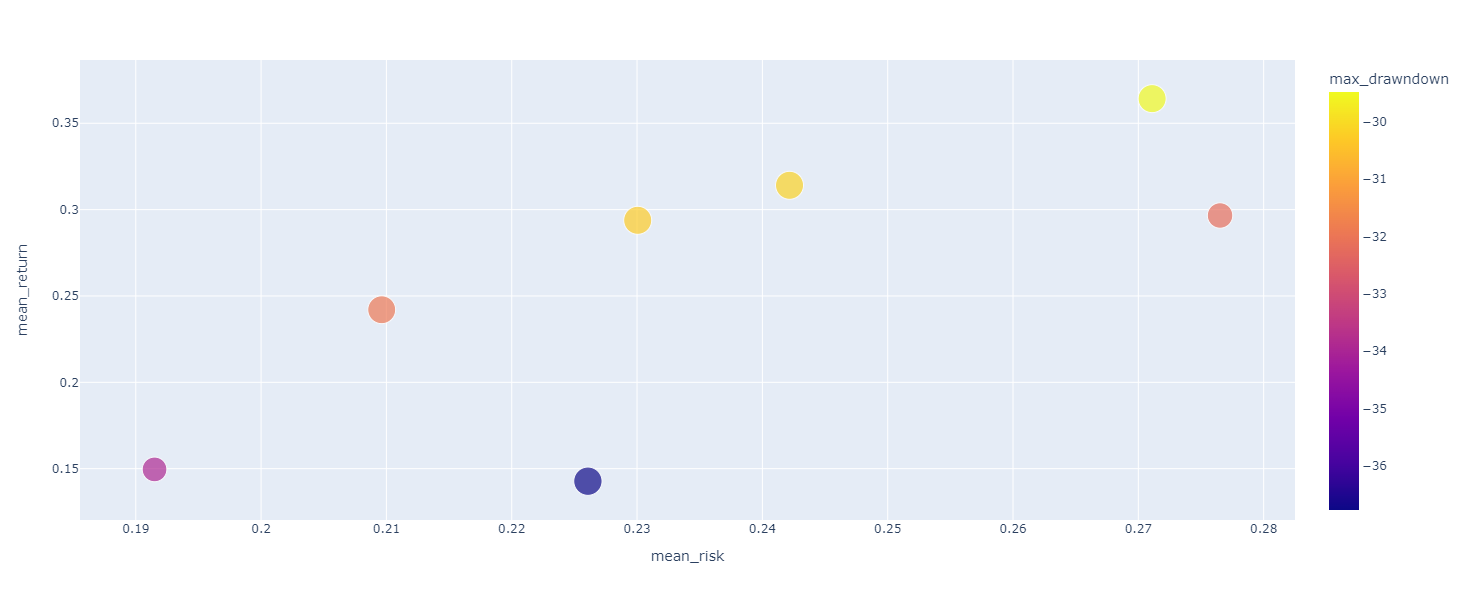

In [172]:
import plotly.express as px
import plotly

fig = px.scatter(df_res_final, x = 'mean_risk', y = 'mean_return', size='max_recovery',  color="max_drawndown", hover_name = 'index', width=800, height=600)
fig.show()

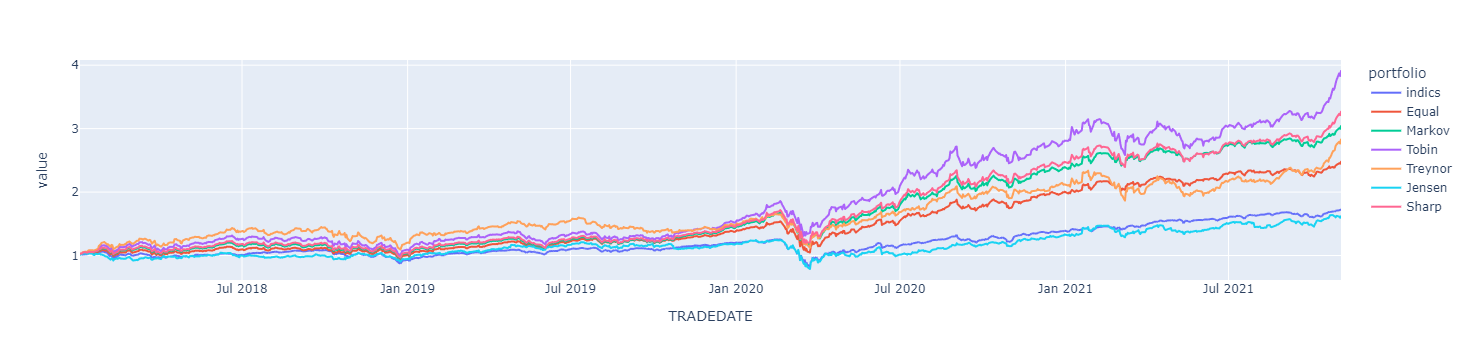

In [173]:
time_res = pd.DataFrame(d).reset_index()
filtr = ['indics', 'Equal', 'Markov', 'Tobin', 'Sharp', 'Treynor', 'Jensen']
time_res_m = pd.melt(time_res, id_vars=['TRADEDATE'], var_name='portfolio')

time_res_m_filtered = time_res_m.query('portfolio in @filtr')
px.line(time_res_m_filtered, x="TRADEDATE", y="value", color='portfolio')

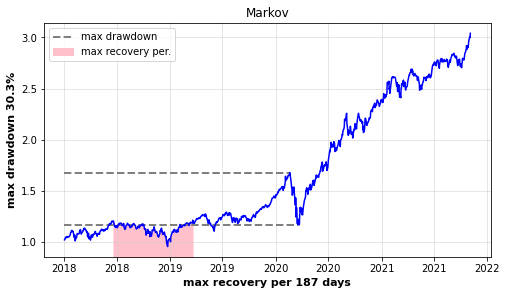

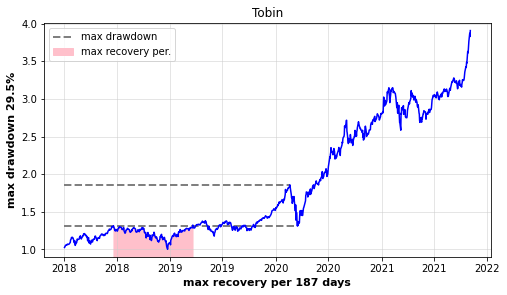

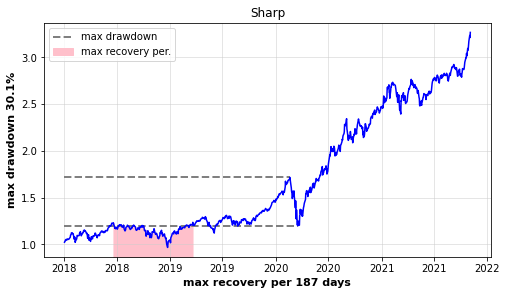

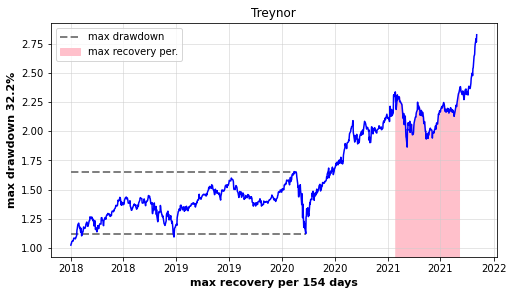

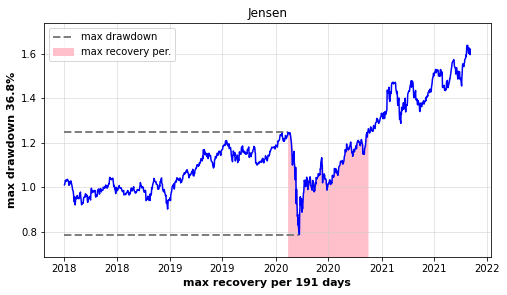

In [174]:
portfolios = ['Markov', 'Tobin', 'Sharp', 'Treynor', 'Jensen']

for label in portfolios:
    show_stats_of_stock(d[label], label)

<ipython-input-137-5d2732b82d49>:25: MatplotlibDeprecationWarning:

normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 



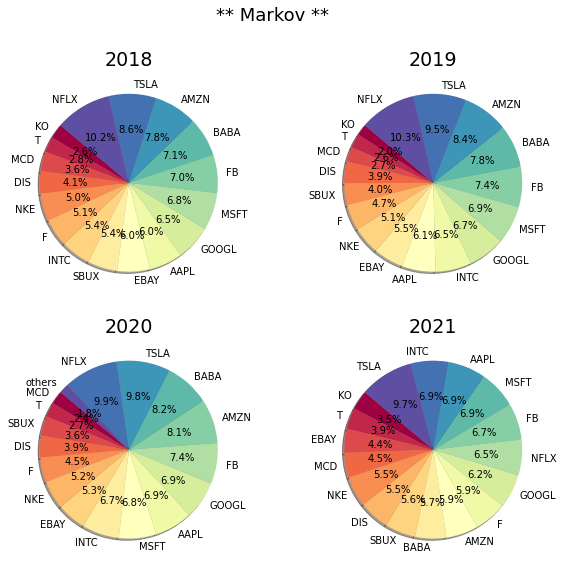

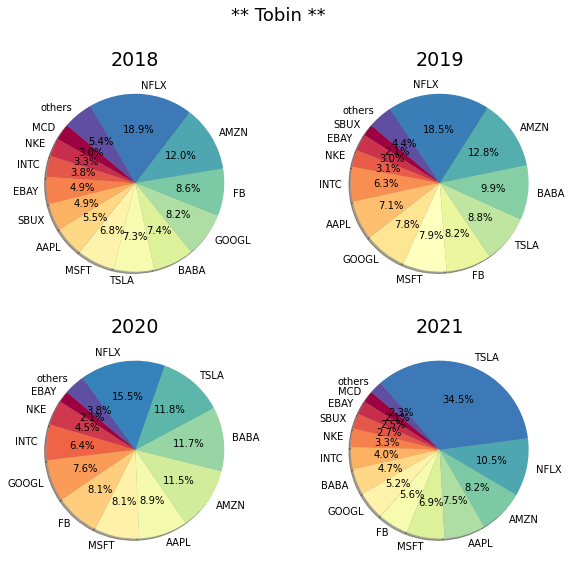

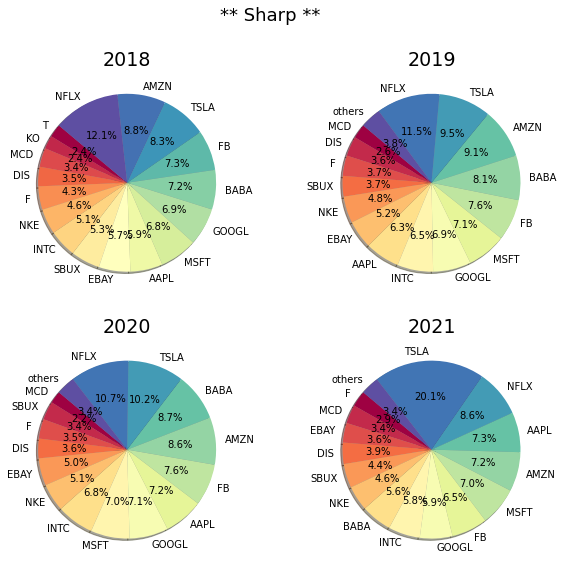

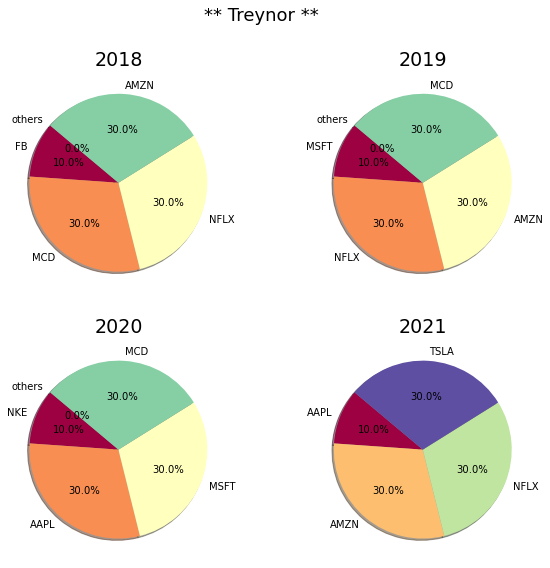

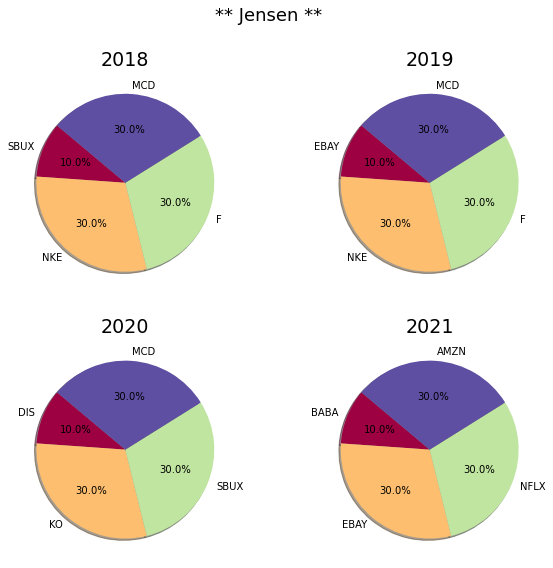

In [175]:
portfolios = ['Markov', 'Tobin', 'Sharp', 'Treynor', 'Jensen']

for label in portfolios:
    weights_year = all_weights_all_years[all_weights_all_years.portfolio == label]
    plot_weights_pie(weights_year.iloc[:, :-1].T.values, label)

In [178]:
weights_year = all_weights_all_years[all_weights_all_years.portfolio == 'Treynor']
weights_year

,2018,2019,2020,2021,portfolio
AAPL,4.572909e-07,1.302324e-06,2.999950e-01,9.999766e-02,Treynor
AMZN,2.999997e-01,2.999989e-01,2.534749e-06,2.999992e-01,Treynor
BABA,6.329159e-07,1.658606e-06,3.268819e-06,2.809995e-07,Treynor
DIS,3.945017e-07,5.412474e-07,7.211387e-07,2.961740e-07,Treynor
EBAY,6.107615e-07,4.099334e-07,3.163181e-07,3.527358e-07,Treynor
F,1.997259e-07,2.010647e-07,1.747184e-07,1.753717e-07,Treynor
FB,9.999482e-02,5.571262e-07,6.330035e-07,2.415488e-07,Treynor
GOOGL,1.121823e-06,7.154511e-07,4.642970e-07,2.626866e-07,Treynor
INTC,3.098274e-07,6.334103e-07,4.153809e-07,1.848447e-07,Treynor
KO,6.929075e-07,1.456639e-06,3.789264e-06,3.054689e-07,Treynor


In [177]:
weights_year = all_weights_all_years[all_weights_all_years.portfolio == 'Jensen']
weights_year

,2018,2019,2020,2021,portfolio
AAPL,7.434556e-09,2.926754e-10,2.030889e-11,2.571779e-09,Jensen
AMZN,2.186345e-09,7.814057e-11,1.495866e-11,3.000000e-01,Jensen
BABA,9.173804e-09,1.633497e-10,1.789736e-11,9.999980e-02,Jensen
DIS,7.512961e-08,7.101886e-10,1.000000e-01,2.387942e-08,Jensen
EBAY,1.597043e-08,1.000001e-01,1.495730e-10,3.000000e-01,Jensen
F,3.000000e-01,3.000000e-01,1.199436e-10,2.998766e-08,Jensen
FB,4.596695e-09,4.589621e-10,5.261202e-11,1.177637e-08,Jensen
GOOGL,1.053723e-08,3.472930e-10,5.120101e-11,1.174656e-08,Jensen
INTC,1.498707e-08,2.706028e-10,5.160191e-11,3.044098e-08,Jensen
KO,1.447620e-08,7.480216e-10,3.000000e-01,4.713457e-08,Jensen
